# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from FullHANKSAMModel import FullHANKSAMModelClass
from figures import create_fig, save_fig

# Setup

In [2]:
model = FullHANKSAMModelClass(name='baseline')
model.load_parameters('calibration')
model.load_data()

In [3]:
par = model.par
ss = model.ss

In [4]:
model_HtM_debt = model.copy()
model_HtM_debt.load_parameters('calibration_HtM_debt')
model_HtM_debt.load_data()

In [5]:
models = [model,model_HtM_debt]

# Solve

In [6]:
for model_ in models:
    model_.par.jump_shock_TFP = 0.0
    model_.par.phi_obar_ss = 0.65
    model_.par.phi_ubar = 0.50
    model_.find_ss()
    model_.compute_jacs(skip_shocks=True)

## Policy experiments

In [7]:
varlist = [
    ('phi_obar','unemployment benefits',(0.0,1.0)),
    ('u_bar','duration of unemployment benefits',(0.0,1.0)),
    ('u','unemployment rate',(-0.015,0.0)),
    ('qB','value of government debt',(-0.05,0.05)),
    ('tau','tax rate',(-0.20,1.0)),
]

In [8]:
d = {}
d['phi_obar'] = 0.01*ss.phi_obar

In [9]:
cost = d['phi_obar']*ss.w*ss.U_UI_hh

In [10]:
dist_at_exhuastion = np.sum(ss.Dz[par.i_u_hh == np.int64(ss.u_bar)+1])
cost_full_extension = (par.phi_obar_ss-par.phi_ubar)*dist_at_exhuastion
d['u_bar'] = cost/cost_full_extension
assert d['u_bar'] < 1

In [11]:
d['wage_subsidy'] = cost/(1-ss.u)
d['hiring_subsidy'] = cost/(ss.lambda_v*ss.vt)
d['G'] = cost
d['public_transfer'] = cost

In [12]:
polnames = {}
polnames['phi_obar'] = 'UI level'
polnames['u_bar'] = 'UI duration'
polnames['G'] = 'public spending'
polnames['public_transfer'] = 'public transfer'
polnames['hiring_subsidy'] = 'hiring subsidy'
polnames['wage_subsidy'] = 'wage subsidy'

In [13]:
for k,v in d.items():
    print(f'{k}, {polnames[k]}: {v:.5f}')

phi_obar, UI level: 0.00650
u_bar, UI duration: 0.74051
wage_subsidy, wage subsidy: 0.00012
hiring_subsidy, hiring subsidy: 0.00432
G, public spending: 0.00011
public_transfer, public transfer: 0.00011


In [14]:
IRFs = {}
K = 100
rho = 0.80
for model_,name in [(model,'baseline'),(model_HtM_debt,'HtM_debt')]:
    
    print(name)
    
    for pol,value in d.items():
        
        print(f' {pol}')
        
        shock_specs = {f'd{pol}':np.zeros(par.T)}
        shock_specs[f'd{pol}'][:K] += value*rho**np.arange(K)
        model_.find_transition_path(shock_specs=shock_specs,do_end_check=False)
    
        for varname,_,_ in varlist:
            IRFs[(name,varname,pol)] = model_.get_IRF(varname)
    
    print('')

baseline
 phi_obar
 u_bar
 wage_subsidy
 hiring_subsidy
 G
 public_transfer

HtM_debt
 phi_obar
 u_bar
 wage_subsidy
 hiring_subsidy
 G
 public_transfer



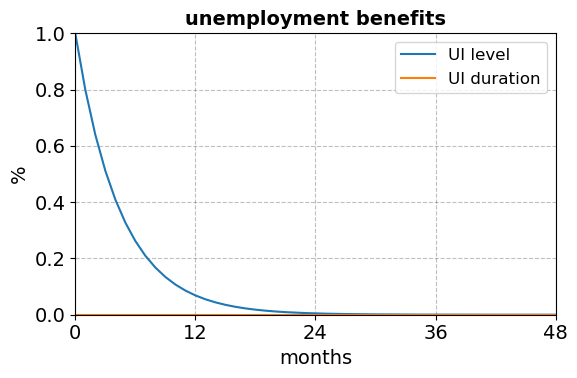

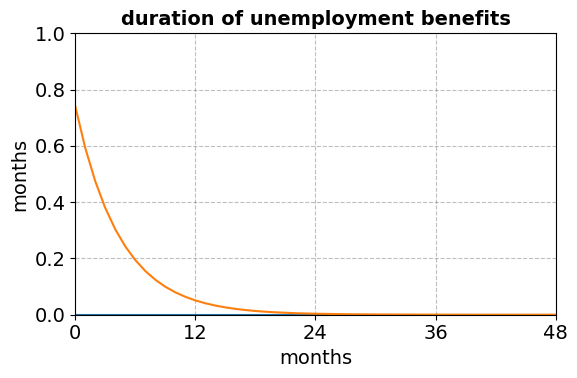

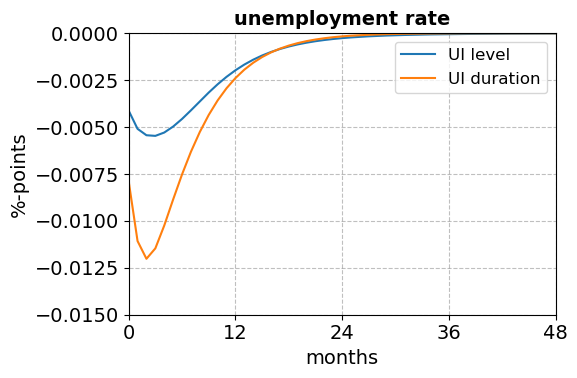

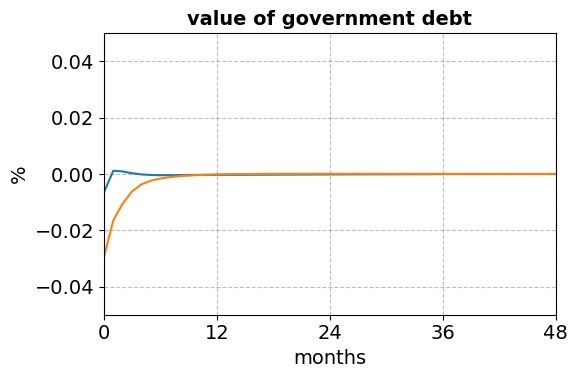

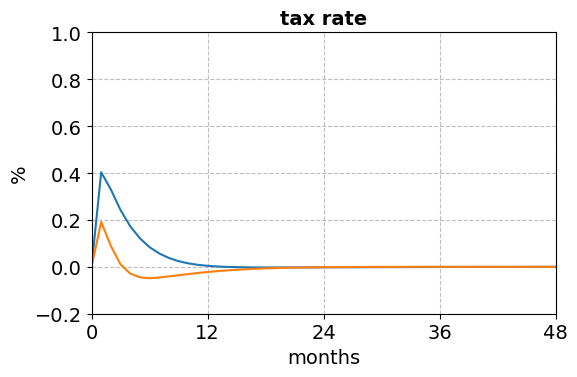

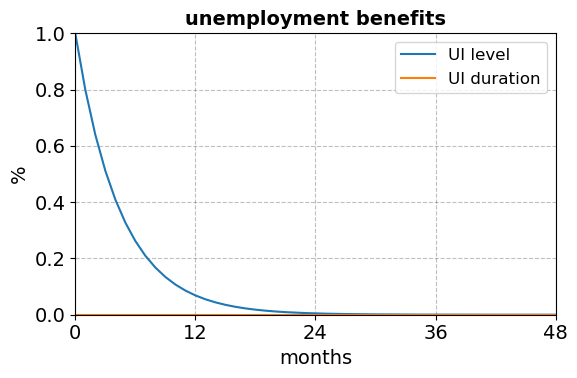

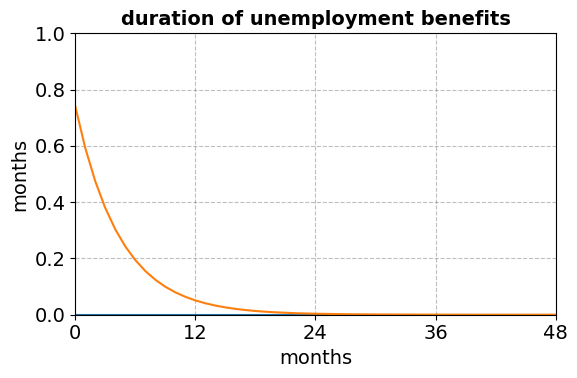

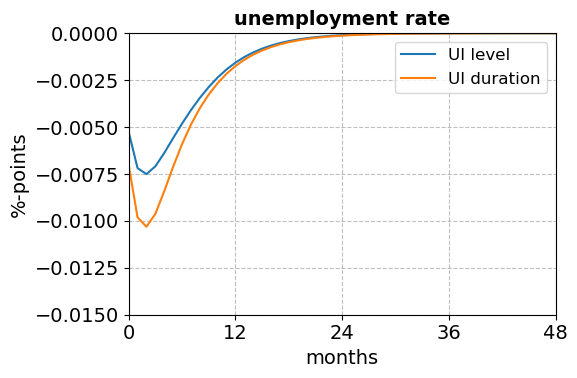

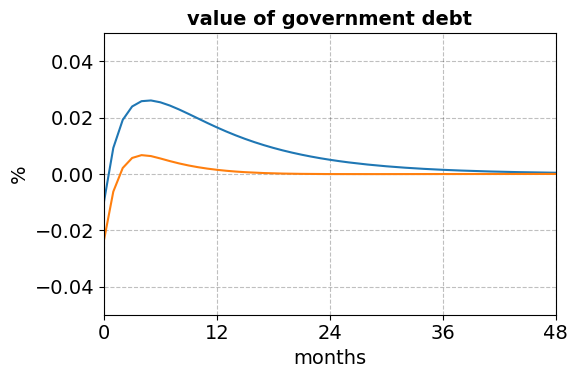

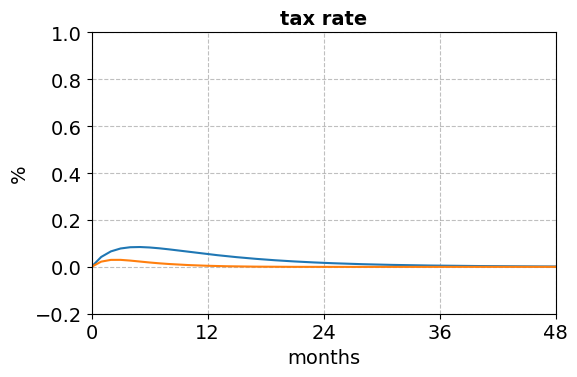

In [15]:
for model_,name in [(model,'baseline'),(model_HtM_debt,'HtM_debt')]:
    for varname,title,ylim in varlist:
    
        fig,ax = create_fig()    

        for pol in ['phi_obar','u_bar']:
            
            polname = polnames[pol]

            IRF,ylabel = IRFs[(name,varname,pol)]
            ax.plot(IRF,label=polname)
        
        ax.set_ylim(ylim)
        save_fig(fig,ax,
                 filename=f'pols_{varname}_{name}',
                 title=title,
                 ylabel=ylabel,legend=(varname in ['u','phi_obar']))
        
        plt.show()

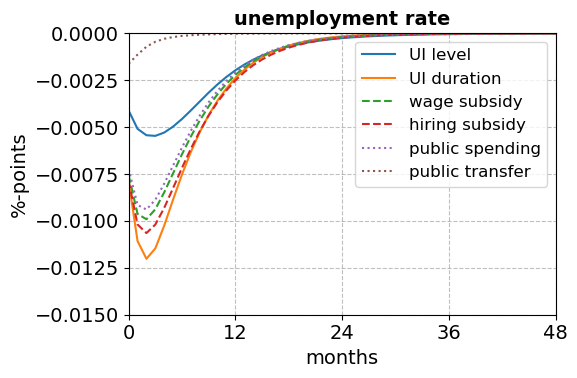

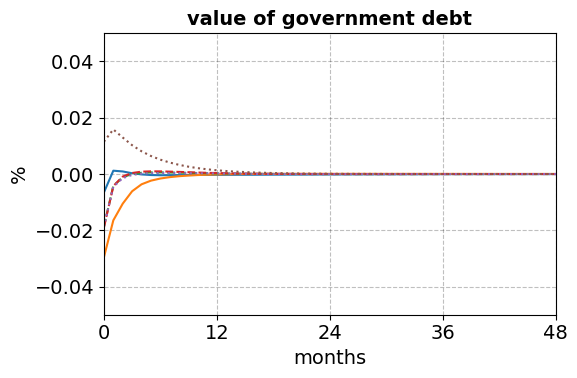

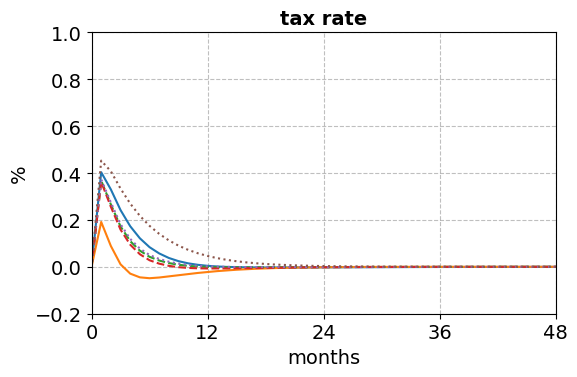

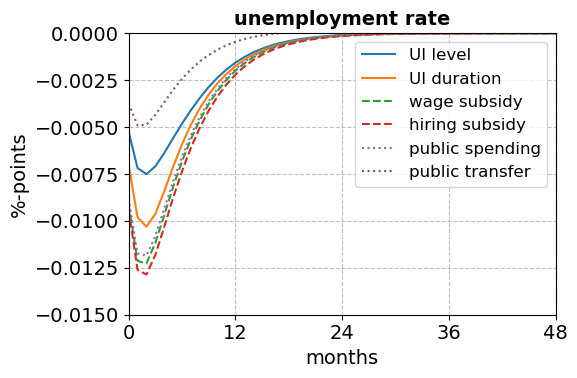

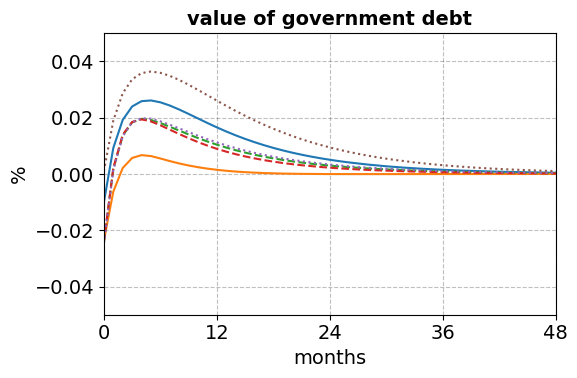

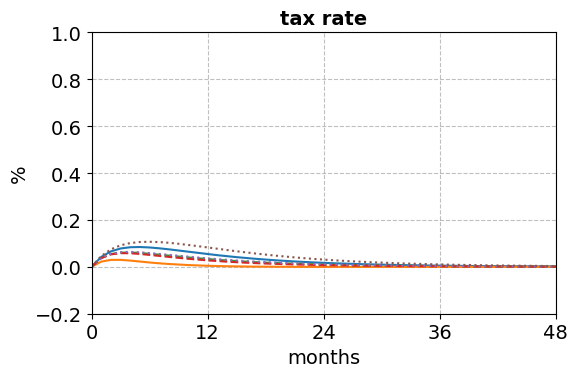

In [16]:
for model_,name in [(model,'baseline'),(model_HtM_debt,'HtM_debt')]:
    for varname,title,ylim in varlist[2:]:
    
        fig,ax = create_fig()    

        for i,pol in enumerate(d.keys()):
            
            if i <= 1:
                ls = '-'
            elif i <= 3:
                ls = '--'
            else:
                ls = ':'                
                
            polname = polnames[pol]

            IRF,ylabel = IRFs[(name,varname,pol)]
            ax.plot(IRF,label=polname,ls=ls)
        
        ax.set_ylim(ylim)
        save_fig(fig,ax,
                 filename=f'pols_all_{varname}_{name}',
                 title=title,
                 ylabel=ylabel,legend=(varname in ['u','phi_obar']))
        
        plt.show()